In [1]:
import pandas as pd
from sqlalchemy import create_engine
import urllib.request
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import json

In [2]:
engine = create_engine('sqlite:///nba.sqlite')

In [3]:
engine.table_names()

['player', 'player_team', 'team']

The first step is to explore each table in the file "nba.sqlite"

In [4]:
with engine.connect() as conn:
    result = conn.execute('SELECT * FROM player')
    player = pd.DataFrame(result.fetchall())
    player.columns = result.keys()

player.head()

,personId,teamId,firstName,lastName,temporaryDisplayName,jersey,isActive,pos,heightFeet,heightInches,...,dateOfBirthUTC,nbaDebutYear,yearsPro,collegeName,lastAffiliation,country,draftTeamId,draftPickNum,draftRoundNum,draftSeasonYear
0,1629121,1610612737,Jaylen,Adams,"Adams, Jaylen",10,1,G,6,2,...,1996-05-04,2018.0,0,St. Bonaventure,St. Bonaventure/USA,USA,NaN,NaN,NaN,NaN
1,203500,1610612760,Steven,Adams,"Adams, Steven",12,1,C,7,0,...,1993-07-20,2013.0,5,Pittsburgh,Pittsburgh/New Zealand,New Zealand,1.610613e+09,12.0,1.0,2013.0
2,1628389,1610612748,Bam,Adebayo,"Adebayo, Bam",13,1,C-F,6,10,...,1997-07-18,2017.0,1,Kentucky,Kentucky/USA,USA,1.610613e+09,14.0,1.0,2017.0
3,1629061,1610612739,Deng,Adel,"Adel, Deng",32,1,F,6,7,...,1997-02-01,2018.0,0,,South Sudan/South Sudan,South Sudan,NaN,NaN,NaN,NaN
4,200746,1610612759,LaMarcus,Aldridge,"Aldridge, LaMarcus",12,1,C-F,6,11,...,1985-07-19,2006.0,12,Texas,Texas/USA,USA,1.610613e+09,2.0,1.0,2006.0


In [5]:
with engine.connect() as conn:
    result = conn.execute('SELECT * FROM team')
    team = pd.DataFrame(result.fetchall())
    team.columns = result.keys()

team.head()

,teamId,isNBAFranchise,isAllStar,city,altCityName,fullName,tricode,nickname,urlName,confName,divName
0,1610616843,0,1,USA,USA,USA,USA,USA,usa,East,East
1,1610616844,0,1,World,World,World,WLD,World,world,East,East
2,1699999999,0,1,Team,Team,All-Stars,EST,All-Stars,assn_away,East,East
3,1699999998,0,1,Team,Team,All-Stars,WST,All-Stars,assn_home,West,West
4,1610616833,0,1,Team Giannis,Team Giannis,Team Giannis,GNS,Team Giannis,team_giannis,East,East


In [6]:
with engine.connect() as conn:
    result = conn.execute('SELECT * FROM player_team')
    player_team = pd.DataFrame(result.fetchall())
    player_team.columns = result.keys()

player_team.head()

,personId,teamId,seasonStart,seasonEnd
0,1629121,1610612737,2018,2018
1,203500,1610612760,2013,2018
2,1628389,1610612748,2017,2018
3,1629061,1610612739,2018,2018
4,200746,1610612757,2006,2014


Secondly, I am going to replace "team ID" from player table and extract the needed information from team table.

In [7]:
query = '''SELECT personId, firstName, lastName, team.teamId, fullName, nickname, city, heightMeters, 
weightPounds, dateOfBirthUTC, yearsPro, pos, draftPickNum, draftRoundNum, collegeName, country FROM player JOIN team ON team.teamId=player.teamId'''
df = pd.read_sql_query(query, engine)
df.head()


,personId,firstName,lastName,teamId,fullName,nickname,city,heightMeters,weightPounds,dateOfBirthUTC,yearsPro,pos,draftPickNum,draftRoundNum,collegeName,country
0,1629121,Jaylen,Adams,1610612737,Atlanta Hawks,Hawks,Atlanta,1.88,190,1996-05-04,0,G,NaN,NaN,St. Bonaventure,USA
1,203500,Steven,Adams,1610612760,Oklahoma City Thunder,Thunder,Oklahoma City,2.13,265,1993-07-20,5,C,12.0,1.0,Pittsburgh,New Zealand
2,1628389,Bam,Adebayo,1610612748,Miami Heat,Heat,Miami,2.08,255,1997-07-18,1,C-F,14.0,1.0,Kentucky,USA
3,1629061,Deng,Adel,1610612739,Cleveland Cavaliers,Cavaliers,Cleveland,2.01,200,1997-02-01,0,F,NaN,NaN,,South Sudan
4,200746,LaMarcus,Aldridge,1610612759,San Antonio Spurs,Spurs,San Antonio,2.11,260,1985-07-19,12,C-F,2.0,1.0,Texas,USA


Now, it is time to download data for each player from internet. At first, I creat a dictionary for all links available
to be downloaded from NBA website. Then I will use a proper loop to download all the data if there is no such file in the directory.

In [8]:
personId = df["personId"]
personId

0      1629121
1       203500
2      1628389
3      1629061
4       200746
5      1628959
6      1628960
7      1628386
8      1628443
9       202329
10     1626147
11      203937
12      201583
13      203507
14     1628961
15     1628384
16     1627853
17        2772
18      201571
19     1629028
20     1628407
21     1628963
22     1628366
23     1628964
24      200826
25      203084
26      203115
27     1628966
28      201587
29      201573
        ...   
467     202322
468    1627820
469     202954
470     203933
471    1627395
472    1629139
473    1629118
474     201566
475    1628401
476    1627785
477     202355
478     203952
479    1626210
480     203710
481    1629140
482    1629026
483     101150
484     101107
485    1627786
486    1629057
487    1628391
488    1626159
489    1626174
490    1626153
491    1627824
492     201152
493    1629027
494     203469
495    1627790
496    1627826
Name: personId, Length: 497, dtype: int64

In [9]:
personId[1]

203500

In [10]:
dl_dict = {}

for ID in personId:
        
    dl_dict[ID] = 'https://data.nba.net/prod/v1/2018/players/{}_profile.json'.format(ID)
dl_dict

{1629121: 'https://data.nba.net/prod/v1/2018/players/1629121_profile.json',
 203500: 'https://data.nba.net/prod/v1/2018/players/203500_profile.json',
 1628389: 'https://data.nba.net/prod/v1/2018/players/1628389_profile.json',
 1629061: 'https://data.nba.net/prod/v1/2018/players/1629061_profile.json',
 200746: 'https://data.nba.net/prod/v1/2018/players/200746_profile.json',
 1628959: 'https://data.nba.net/prod/v1/2018/players/1628959_profile.json',
 1628960: 'https://data.nba.net/prod/v1/2018/players/1628960_profile.json',
 1628386: 'https://data.nba.net/prod/v1/2018/players/1628386_profile.json',
 1628443: 'https://data.nba.net/prod/v1/2018/players/1628443_profile.json',
 202329: 'https://data.nba.net/prod/v1/2018/players/202329_profile.json',
 1626147: 'https://data.nba.net/prod/v1/2018/players/1626147_profile.json',
 203937: 'https://data.nba.net/prod/v1/2018/players/203937_profile.json',
 201583: 'https://data.nba.net/prod/v1/2018/players/201583_profile.json',
 203507: 'https://data

In [11]:
path = "/Users/behnam/Documents/University Docs/Spring 2019/IENG 493D/Project 2"
os.listdir(path)

['1627747.json',
 '1628518.json',
 '1626156.json',
 '101123.json',
 '1629020.json',
 '1628959.json',
 '1628373.json',
 '201967.json',
 '201988.json',
 '201571.json',
 'project 2.pdf',
 '201588.json',
 '1628365.json',
 '201567.json',
 '1629061.json',
 '1627751.json',
 '1627395.json',
 '1628963.json',
 '203960.json',
 '1628467.json',
 '203521.json',
 '202330.json',
 '1626245.json',
 '2736.json',
 '203937.json',
 '1628021.json',
 '1626195.json',
 '202326.json',
 '1627854.json',
 '1628975.json',
 '203999.json',
 '1626204.json',
 '203901.json',
 '1627823.json',
 '1629094.json',
 '1628390.json',
 '203110.json',
 '1626224.json',
 '204456.json',
 '1628369.json',
 '201584.json',
 '101181.json',
 '202347.json',
 '1628386.json',
 '1628410.json',
 '203917.json',
 '203501.json',
 '101139.json',
 '202691.json',
 '1628980.json',
 '1629016.json',
 '203487.json',
 '203468.json',
 '1627788.json',
 '1627767.json',
 '202687.json',
 '1629057.json',
 '203079.json',
 '1628979.json',
 '1628978.json',
 '201229

In [12]:
for key, value in dl_dict.items():
    if '{}.json'.format(key) not in os.listdir(path):
        urllib.request.urlretrieve(value, '{}.json'.format(key))
    else:
        continue

The following is a data file I downloaded.

In [13]:
with open('1629121.json', 'r') as f:
        datastore = json.load(f)
datastore

{'_internal': {'pubDateTime': '2019-04-03 18:10:26.386 EDT',
  'igorPath': 'S3,1554329412887,1554329412977|router,1554329412977,1554329413074|xmlProcessor,1554329413331,1554329413750|domUpdater,1554329418149,1554329426219|feedProducer,1554329426352,1554329426389',
  'xslt': 'NBA/xsl/player/marty_player_profile.xsl',
  'xsltForceRecompile': 'true',
  'xsltInCache': 'false',
  'xsltCompileTimeMillis': '24',
  'xsltTransformTimeMillis': '3',
  'consolidatedDomKey': 'prod__transform__marty_player_profile__16075727569819',
  'endToEndTimeMillis': '13502'},
 'league': {'standard': {'teamId': '1610612737',
   'stats': {'latest': {'seasonYear': 2018,
     'seasonStageId': 2,
     'ppg': '3',
     'rpg': '1.6',
     'apg': '1.9',
     'mpg': '11.8',
     'topg': '0.7',
     'spg': '0.3',
     'bpg': '0.1',
     'tpp': '33.8',
     'ftp': '75',
     'fgp': '33.7',
     'assists': '56',
     'blocks': '4',
     'steals': '8',
     'turnovers': '21',
     'offReb': '10',
     'defReb': '39',
     

To analyze the data, first, I am going to provide high level statistics of all players for their heights, weights, team names, college names, and ages.

In [14]:
df["heightMeters"]

0      1.88
1      2.13
2      2.08
3      2.01
4      2.11
5      1.96
6      1.96
7      2.11
8      1.90
9      2.06
10     1.98
11     2.06
12     2.08
13     2.11
14     2.08
15     2.03
16     1.90
17     2.03
18     1.83
19     2.16
20     2.01
21     2.11
22     1.98
23     2.13
24     1.83
25     2.03
26     1.98
27     2.06
28     2.03
29     1.90
       ... 
467    1.93
468    1.96
469    1.93
470    2.03
471    2.03
472    2.06
473    2.13
474    1.90
475    1.93
476    1.93
477    2.13
478    2.03
479    2.03
480    1.96
481    2.06
482    2.01
483    1.85
484    2.06
485    2.01
486    2.08
487    2.08
488    2.01
489    2.08
490    1.96
491    2.03
492    2.03
493    1.88
494    2.13
495    2.11
496    2.16
Name: heightMeters, Length: 497, dtype: float64

Text(0, 0.5, 'Number of players')

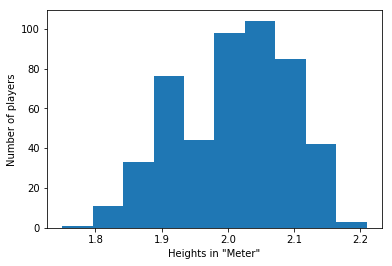

In [15]:
plt.hist(df["heightMeters"], bins=10)
plt.xlabel('Heights in "Meter"')
plt.ylabel('Number of players')

Text(0, 0.5, 'Number of players')

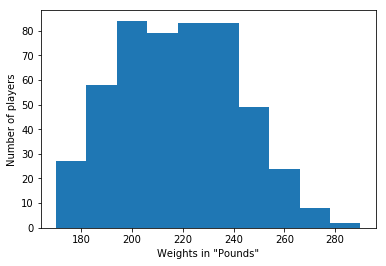

In [16]:
plt.hist(df["weightPounds"], bins=10)
plt.xlabel('Weights in "Pounds"')
plt.ylabel('Number of players')

In [17]:
# Team names

team_names = pd.unique(df["nickname"])
team_names

array(['Hawks', 'Thunder', 'Heat', 'Cavaliers', 'Spurs', 'Bulls', 'Jazz',
       'Nets', 'Knicks', 'Trail Blazers', 'Grizzlies', 'Bucks',
       'Mavericks', 'Raptors', 'Wizards', 'Magic', 'Suns', 'Hornets',
       'Kings', 'Lakers', 'Nuggets', 'Timberwolves', 'Celtics',
       'Warriors', 'Pelicans', 'Clippers', 'Pacers', '76ers', 'Pistons',
       'Rockets'], dtype=object)

In [18]:
team_members = df.groupby("nickname")["personId"].count()
team_members

nickname
76ers            17
Bucks            16
Bulls            17
Cavaliers        17
Celtics          17
Clippers         17
Grizzlies        18
Hawks            17
Heat             15
Hornets          17
Jazz             17
Kings            17
Knicks           16
Lakers           17
Magic            18
Mavericks        17
Nets             16
Nuggets          17
Pacers           16
Pelicans         16
Pistons          17
Raptors          16
Rockets          16
Spurs            16
Suns             16
Thunder          16
Timberwolves     17
Trail Blazers    15
Warriors         17
Wizards          16
Name: personId, dtype: int64

In [19]:
team_dict = {}
for name in team_names:
    team_dict[name] = team_members[name]
team_dict

{'Hawks': 17,
 'Thunder': 16,
 'Heat': 15,
 'Cavaliers': 17,
 'Spurs': 16,
 'Bulls': 17,
 'Jazz': 17,
 'Nets': 16,
 'Knicks': 16,
 'Trail Blazers': 15,
 'Grizzlies': 18,
 'Bucks': 16,
 'Mavericks': 17,
 'Raptors': 16,
 'Wizards': 16,
 'Magic': 18,
 'Suns': 16,
 'Hornets': 17,
 'Kings': 17,
 'Lakers': 17,
 'Nuggets': 17,
 'Timberwolves': 17,
 'Celtics': 17,
 'Warriors': 17,
 'Pelicans': 16,
 'Clippers': 17,
 'Pacers': 16,
 '76ers': 17,
 'Pistons': 17,
 'Rockets': 16}

Text(0, 0.5, 'Number of players who play for the team')

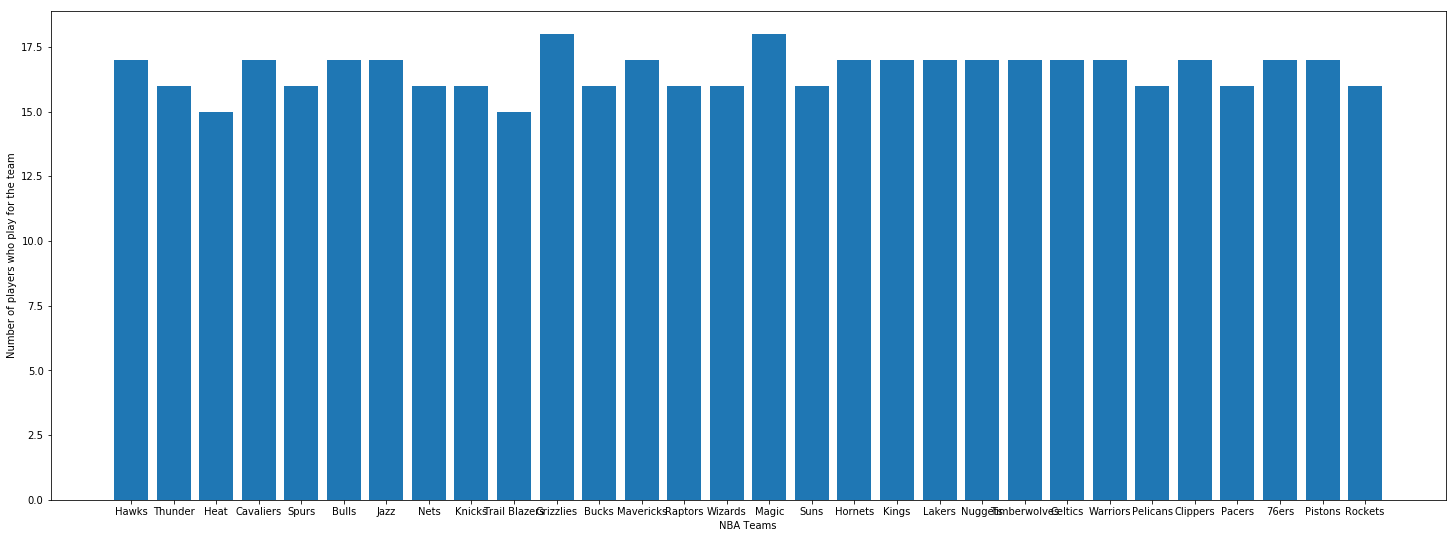

In [20]:
plt.figure(figsize=(25, 9))
x = team_dict.keys()
y = list(team_dict.values())
plt.bar(x, y)
plt.xlabel('NBA Teams')
plt.ylabel('Number of players who play for the team')


In [21]:
# College names

college_names = pd.unique(df["collegeName"])
college_names

array(['St. Bonaventure', 'Pittsburgh', 'Kentucky', '', 'Texas', 'Duke',
       'Arizona', 'Wake Forest', 'Virginia', 'UCLA', 'California',
       'Greece', 'Dayton', 'Indiana', 'Villanova', 'Florida State',
       'California-Los Angeles', 'Northeastern', 'North Carolina',
       'Memphis', 'Ohio State', 'Lisieux, France', 'Washington State',
       'Old Dominion', 'Florida', 'Bologna, Italy', 'Oregon',
       "Saint Joseph's", 'Arkansas', 'Nevada-Las Vegas',
       'Lubumbashi, DR Congo', 'Louisiana State', 'Clemson',
       'Xavier (Ohio)', 'Utah', 'Michigan State', 'Miami (FL)',
       'Southern Methodist', 'Michigan', 'Colorado', 'Iowa State',
       'Marquette', 'Villanueva de la Serena, Spain', 'Georgia',
       'Missouri', 'West Virginia', 'Syracuse', 'Texas A&M', 'Cincinnati',
       'George Washington', 'Dominquez H.S', 'DePaul', 'Charleston (SC)',
       'Washington', 'Belmont', 'Gonzaga', 'Notre Dame',
       'Tennessee State', 'South Carolina Upstate', 'Davidson',
       '

In [22]:
college_members = df.groupby("collegeName")["personId"].count()
college_dict = {}
for name in college_names:
    if name == "":
        continue
    college_dict[name] = college_members[name]
college_dict

{'St. Bonaventure': 1,
 'Pittsburgh': 2,
 'Kentucky': 28,
 'Texas': 10,
 'Duke': 23,
 'Arizona': 11,
 'Wake Forest': 6,
 'Virginia': 4,
 'UCLA': 10,
 'California': 5,
 'Greece': 1,
 'Dayton': 1,
 'Indiana': 8,
 'Villanova': 8,
 'Florida State': 3,
 'California-Los Angeles': 4,
 'Northeastern': 1,
 'North Carolina': 12,
 'Memphis': 3,
 'Ohio State': 5,
 'Lisieux, France': 1,
 'Washington State': 2,
 'Old Dominion': 1,
 'Florida': 8,
 'Bologna, Italy': 1,
 'Oregon': 5,
 "Saint Joseph's": 2,
 'Arkansas': 4,
 'Nevada-Las Vegas': 4,
 'Lubumbashi, DR Congo': 1,
 'Louisiana State': 4,
 'Clemson': 2,
 'Xavier (Ohio)': 2,
 'Utah': 4,
 'Michigan State': 8,
 'Miami (FL)': 3,
 'Southern Methodist': 4,
 'Michigan': 9,
 'Colorado': 5,
 'Iowa State': 5,
 'Marquette': 5,
 'Villanueva de la Serena, Spain': 1,
 'Georgia': 2,
 'Missouri': 3,
 'West Virginia': 1,
 'Syracuse': 5,
 'Texas A&M': 5,
 'Cincinnati': 3,
 'George Washington': 2,
 'Dominquez H.S': 1,
 'DePaul': 1,
 'Charleston (SC)': 1,
 'Washingt

Text(0, 0.5, 'Number of players from a specified college')

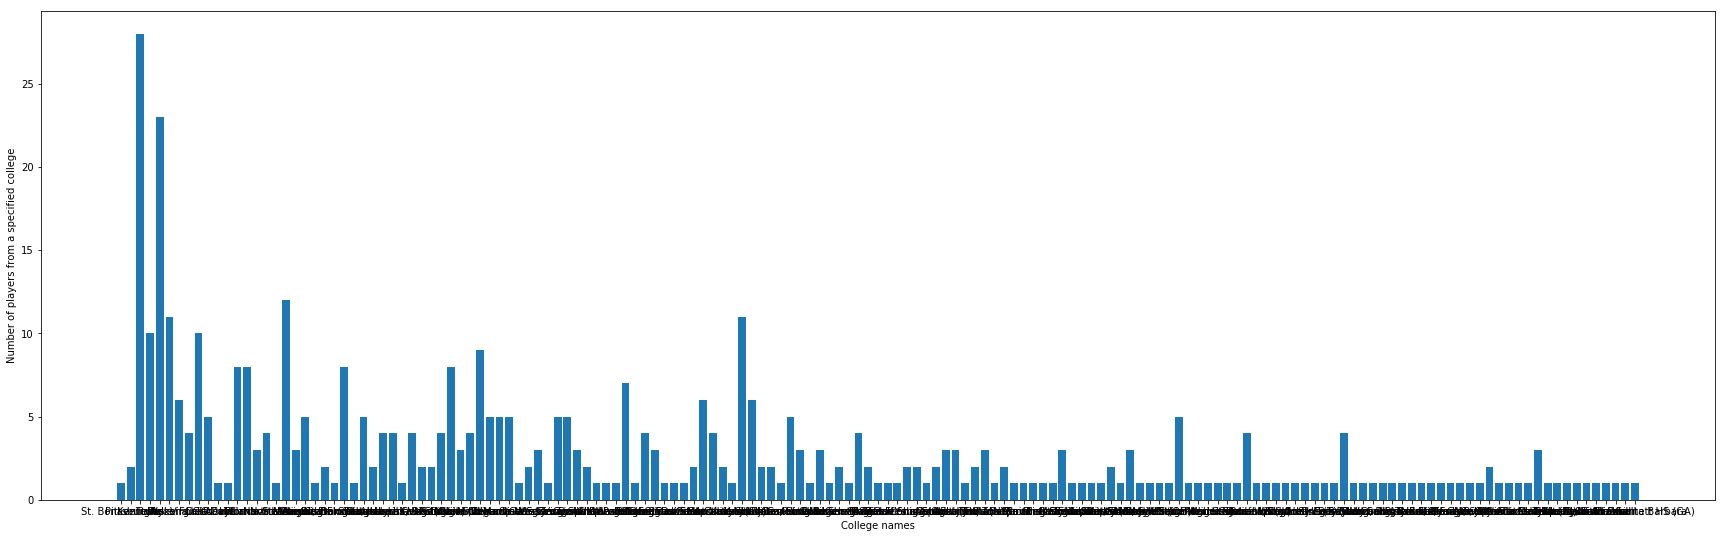

In [23]:
plt.figure(figsize=(30, 9))
x = college_dict.keys()
y = list(college_dict.values())
plt.bar(x, y)
plt.xlabel('College names')
plt.ylabel('Number of players from a specified college')

Since the plot for college names is very confusing because of the number of college names, I use the following coe to have a proper plot for top 5 colleges with the number of players from each college.

In [24]:
top_5_colleges = college_members[(college_members > 10)]
top_5_colleges = top_5_colleges.sort_values(ascending=True)
top_5_colleges

collegeName
Arizona           11
Kansas            11
North Carolina    12
Duke              23
Kentucky          28
                  61
Name: personId, dtype: int64

Text(0, 0.5, 'Number of players from a specified college')

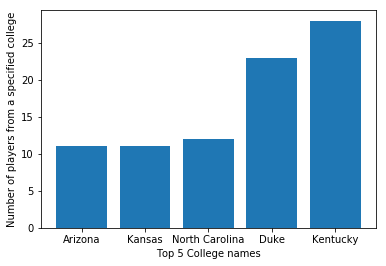

In [25]:
colleges = ['Arizona', 'Kansas', 'North Carolina', 'Duke', 'Kentucky']
x = np.arange(len(colleges))
plt.xticks(x, colleges)

values = []
for value in top_5_colleges:
    if value == 61:
        continue
    values.append(value)
plt.bar(x, values)
plt.xlabel('Top 5 College names')
plt.ylabel('Number of players from a specified college')

To have a plot of the players' ages, first, I need to find their ages. The date of birth for each player is provided by the dataset. So, I am going to use pandas feature "pd.to_datetime" to find the age of each player.

In [26]:
df["dateOfBirthUTC"]

0      1996-05-04
1      1993-07-20
2      1997-07-18
3      1997-02-01
4      1985-07-19
5      1997-10-29
6      1995-10-08
7      1998-04-21
8      1993-01-15
9      1990-09-21
10     1993-11-19
11     1993-09-20
12     1988-05-06
13     1994-12-06
14     1997-11-20
15     1997-07-17
16     1994-03-26
17     1985-06-30
18     1987-11-10
19     1998-07-23
20     1995-08-30
21     1999-03-14
22     1997-10-27
23     1998-05-12
24     1984-06-26
25     1992-05-30
26     1991-01-06
27     1996-01-23
28     1988-12-14
29     1988-08-20
          ...    
467    1990-09-06
468    1994-06-10
469    1989-07-25
470    1993-09-05
471    1991-12-18
472    1994-10-13
473    1996-02-03
474    1988-11-12
475    1994-07-02
476    1995-03-08
477    1989-06-13
478    1995-02-23
479    1993-01-28
480    1990-02-06
481    1995-05-22
482    1994-12-02
483    1986-10-27
484    1986-06-19
485    1994-12-30
486    1997-10-17
487    1996-02-19
488    1996-03-26
489    1995-09-27
490    1992-04-26
491    199

In [27]:
df['dateOfBirthUTC'] = pd.to_datetime(df['dateOfBirthUTC'])
now = dt.datetime.now()    
df['dateOfBirthUTC'] = ((now - df['dateOfBirthUTC'])/365).dt.days
df

,personId,firstName,lastName,teamId,fullName,nickname,city,heightMeters,weightPounds,dateOfBirthUTC,yearsPro,pos,draftPickNum,draftRoundNum,collegeName,country
0,1629121,Jaylen,Adams,1610612737,Atlanta Hawks,Hawks,Atlanta,1.88,190,22,0,G,NaN,NaN,St. Bonaventure,USA
1,203500,Steven,Adams,1610612760,Oklahoma City Thunder,Thunder,Oklahoma City,2.13,265,25,5,C,12.0,1.0,Pittsburgh,New Zealand
2,1628389,Bam,Adebayo,1610612748,Miami Heat,Heat,Miami,2.08,255,21,1,C-F,14.0,1.0,Kentucky,USA
3,1629061,Deng,Adel,1610612739,Cleveland Cavaliers,Cavaliers,Cleveland,2.01,200,22,0,F,NaN,NaN,,South Sudan
4,200746,LaMarcus,Aldridge,1610612759,San Antonio Spurs,Spurs,San Antonio,2.11,260,33,12,C-F,2.0,1.0,Texas,USA
5,1628959,Rawle,Alkins,1610612741,Chicago Bulls,Bulls,Chicago,1.96,225,21,0,G,NaN,NaN,,USA
6,1628960,Grayson,Allen,1610612762,Utah Jazz,Jazz,Utah,1.96,198,23,0,G,21.0,1.0,Duke,USA
7,1628386,Jarrett,Allen,1610612751,Brooklyn Nets,Nets,Brooklyn,2.11,237,20,1,C,22.0,1.0,Texas,USA
8,1628443,Kadeem,Allen,1610612752,New York Knicks,Knicks,New York,1.90,200,26,1,G,53.0,2.0,Arizona,USA
9,202329,Al-Farouq,Aminu,1610612757,Portland Trail Blazers,Trail Blazers,Portland,2.06,220,28,8,F,8.0,1.0,Wake Forest,USA


Text(0, 0.5, 'Number of players in a specific age')

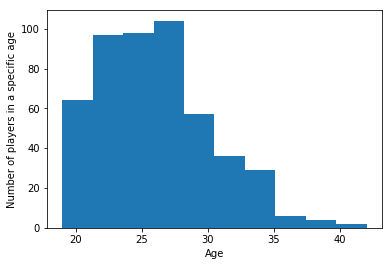

In [28]:
plt.hist(df["dateOfBirthUTC"], bins=10)
plt.xlabel('Age')
plt.ylabel('Number of players in a specific age')

For the rest of this project, I am going to identify some relationships netween players' attributes and the provided metrics in detailed data for each player.

In [29]:
with open('1629061.json', 'r') as f:
        info = json.load(f)
info

{'_internal': {'pubDateTime': '2019-04-03 18:12:14.677 EDT',
  'igorPath': 'S3,1554329529178,1554329529279|router,1554329529279,1554329529451|xmlProcessor,1554329529638,1554329530015|domUpdater,1554329530636,1554329534454|feedProducer,1554329534568,1554329534681',
  'xslt': 'NBA/xsl/player/marty_player_profile.xsl',
  'xsltForceRecompile': 'true',
  'xsltInCache': 'false',
  'xsltCompileTimeMillis': '73',
  'xsltTransformTimeMillis': '13',
  'consolidatedDomKey': 'prod__transform__marty_player_profile__2744508649937',
  'endToEndTimeMillis': '5503'},
 'league': {'standard': {'teamId': '1610612739',
   'stats': {'latest': {'seasonYear': 2018,
     'seasonStageId': 2,
     'ppg': '1.7',
     'rpg': '1.1',
     'apg': '0.3',
     'mpg': '11.6',
     'topg': '0.3',
     'spg': '0.1',
     'bpg': '0.2',
     'tpp': '23.8',
     'ftp': '100',
     'fgp': '29.4',
     'assists': '5',
     'blocks': '4',
     'steals': '1',
     'turnovers': '5',
     'offReb': '2',
     'defReb': '15',
     '

Since the data files we have for each player is a json file, I use the following code to explore within each file and extract what I need. I chose the data for "career Summary" of each data file, so, I can have the metrics such as "field goals percentage", "field goals attempted", etc.

In [30]:
with open('1629061.json', 'r') as f:
        datastore = json.load(f)
        datastore = datastore["league"]["standard"]["stats"]["careerSummary"]
datastore

{'tpp': '23.8',
 'ftp': '100',
 'fgp': '29.4',
 'ppg': '1.7',
 'rpg': '1.1',
 'apg': '0.3',
 'bpg': '0.2',
 'mpg': '11.5',
 'spg': '0.1',
 'assists': '5',
 'blocks': '4',
 'steals': '1',
 'turnovers': '5',
 'offReb': '2',
 'defReb': '15',
 'totReb': '17',
 'fgm': '10',
 'fga': '34',
 'tpm': '5',
 'tpa': '21',
 'ftm': '2',
 'fta': '2',
 'pFouls': '12',
 'points': '27',
 'gamesPlayed': '16',
 'gamesStarted': '3',
 'plusMinus': '-28',
 'min': '184',
 'dd2': '0',
 'td3': '0'}

In this part, I am trying to create a proper table of the metrics of each player associated with their ID. First, I create an empty data frame. Then, I use a loop to add each player's data to this data frame.

In [31]:
DF = pd.DataFrame(datastore, index=[0])
DF

,tpp,ftp,fgp,ppg,rpg,apg,bpg,mpg,spg,assists,...,ftm,fta,pFouls,points,gamesPlayed,gamesStarted,plusMinus,min,dd2,td3
0,23.8,100,29.4,1.7,1.1,0.3,0.2,11.5,0.1,5,...,2,2,12,27,16,3,-28,184,0,0


In [32]:
DF = DF.drop(DF.index[0])
DF

,tpp,ftp,fgp,ppg,rpg,apg,bpg,mpg,spg,assists,...,ftm,fta,pFouls,points,gamesPlayed,gamesStarted,plusMinus,min,dd2,td3


In [33]:
for ID in player["personId"]:
    with open('{}.json'.format(ID), 'r') as f:
        datastore = json.load(f)
        datastore = datastore["league"]["standard"]["stats"]["careerSummary"]
    DF = DF.append(datastore, ignore_index=True)
    
DF

,tpp,ftp,fgp,ppg,rpg,apg,bpg,mpg,spg,assists,...,ftm,fta,pFouls,points,gamesPlayed,gamesStarted,plusMinus,min,dd2,td3
0,33.8,75,33.7,3,1.6,1.9,0.1,11.8,0.3,56,...,6,8,39,91,30,0,-33,354,0,0
1,0,55.4,58.9,9.7,7.4,1,1,26.8,0.9,467,...,755,1364,1250,4473,463,399,1437,12427,89,0
2,10.5,72.8,54.8,7.9,6.4,1.9,0.7,21.6,0.6,277,...,286,393,332,1150,146,43,9,3150,17,0
3,23.8,100,29.4,1.7,1.1,0.3,0.2,11.5,0.1,5,...,2,2,12,27,16,3,-28,184,0,0
4,28.6,81,49.1,19.6,8.4,2,1.1,34.5,0.7,1850,...,3403,4203,2339,18506,946,905,2903,32646,335,0
5,20,100,25,2,2.3,1,0,6.8,0.2,6,...,3,3,2,12,6,0,-10,41,0,0
6,29.7,69,32.2,3.8,0.3,0.5,0.1,9.2,0.1,18,...,29,42,35,127,33,1,-102,302,0,0
7,18.6,73.2,58.8,9.6,6.9,1.1,1.4,23.3,0.5,157,...,308,421,327,1425,148,107,-259,3447,28,0
8,34.1,80,44.4,5.4,1.6,2.2,0.1,13.7,0.5,80,...,44,55,60,195,36,2,-44,493,0,0
9,33.8,74.5,42.3,7.7,6.1,1.2,0.6,25.2,1,824,...,862,1157,1243,5128,666,425,227,16788,52,0


In [34]:
DF["personId"] = player["personId"]
b = DF.columns.tolist()
b = b[-1:] + b[:-1]
DF = DF[b]
DF

,personId,tpp,ftp,fgp,ppg,rpg,apg,bpg,mpg,spg,...,ftm,fta,pFouls,points,gamesPlayed,gamesStarted,plusMinus,min,dd2,td3
0,1629121,33.8,75,33.7,3,1.6,1.9,0.1,11.8,0.3,...,6,8,39,91,30,0,-33,354,0,0
1,203500,0,55.4,58.9,9.7,7.4,1,1,26.8,0.9,...,755,1364,1250,4473,463,399,1437,12427,89,0
2,1628389,10.5,72.8,54.8,7.9,6.4,1.9,0.7,21.6,0.6,...,286,393,332,1150,146,43,9,3150,17,0
3,1629061,23.8,100,29.4,1.7,1.1,0.3,0.2,11.5,0.1,...,2,2,12,27,16,3,-28,184,0,0
4,200746,28.6,81,49.1,19.6,8.4,2,1.1,34.5,0.7,...,3403,4203,2339,18506,946,905,2903,32646,335,0
5,1628959,20,100,25,2,2.3,1,0,6.8,0.2,...,3,3,2,12,6,0,-10,41,0,0
6,1628960,29.7,69,32.2,3.8,0.3,0.5,0.1,9.2,0.1,...,29,42,35,127,33,1,-102,302,0,0
7,1628386,18.6,73.2,58.8,9.6,6.9,1.1,1.4,23.3,0.5,...,308,421,327,1425,148,107,-259,3447,28,0
8,1628443,34.1,80,44.4,5.4,1.6,2.2,0.1,13.7,0.5,...,44,55,60,195,36,2,-44,493,0,0
9,202329,33.8,74.5,42.3,7.7,6.1,1.2,0.6,25.2,1,...,862,1157,1243,5128,666,425,227,16788,52,0


In [35]:
# The columns I have in my new data frame.

DF.columns

Index(['personId', 'tpp', 'ftp', 'fgp', 'ppg', 'rpg', 'apg', 'bpg', 'mpg',
       'spg', 'assists', 'blocks', 'steals', 'turnovers', 'offReb', 'defReb',
       'totReb', 'fgm', 'fga', 'tpm', 'tpa', 'ftm', 'fta', 'pFouls', 'points',
       'gamesPlayed', 'gamesStarted', 'plusMinus', 'min', 'dd2', 'td3'],
      dtype='object')

In [36]:
player

,personId,teamId,firstName,lastName,temporaryDisplayName,jersey,isActive,pos,heightFeet,heightInches,...,dateOfBirthUTC,nbaDebutYear,yearsPro,collegeName,lastAffiliation,country,draftTeamId,draftPickNum,draftRoundNum,draftSeasonYear
0,1629121,1610612737,Jaylen,Adams,"Adams, Jaylen",10,1,G,6,2,...,1996-05-04,2018.0,0,St. Bonaventure,St. Bonaventure/USA,USA,NaN,NaN,NaN,NaN
1,203500,1610612760,Steven,Adams,"Adams, Steven",12,1,C,7,0,...,1993-07-20,2013.0,5,Pittsburgh,Pittsburgh/New Zealand,New Zealand,1.610613e+09,12.0,1.0,2013.0
2,1628389,1610612748,Bam,Adebayo,"Adebayo, Bam",13,1,C-F,6,10,...,1997-07-18,2017.0,1,Kentucky,Kentucky/USA,USA,1.610613e+09,14.0,1.0,2017.0
3,1629061,1610612739,Deng,Adel,"Adel, Deng",32,1,F,6,7,...,1997-02-01,2018.0,0,,South Sudan/South Sudan,South Sudan,NaN,NaN,NaN,NaN
4,200746,1610612759,LaMarcus,Aldridge,"Aldridge, LaMarcus",12,1,C-F,6,11,...,1985-07-19,2006.0,12,Texas,Texas/USA,USA,1.610613e+09,2.0,1.0,2006.0
5,1628959,1610612741,Rawle,Alkins,"Alkins, Rawle",20,1,G,6,5,...,1997-10-29,2018.0,0,,USA/USA,USA,NaN,NaN,NaN,NaN
6,1628960,1610612762,Grayson,Allen,"Allen, Grayson",24,1,G,6,5,...,1995-10-08,2018.0,0,Duke,Duke University/USA,USA,1.610613e+09,21.0,1.0,2018.0
7,1628386,1610612751,Jarrett,Allen,"Allen, Jarrett",31,1,C,6,11,...,1998-04-21,2017.0,1,Texas,Texas/USA,USA,1.610613e+09,22.0,1.0,2017.0
8,1628443,1610612752,Kadeem,Allen,"Allen, Kadeem",0,1,G,6,3,...,1993-01-15,2017.0,1,Arizona,ArizonaUSA/USA,USA,1.610613e+09,53.0,2.0,2017.0
9,202329,1610612757,Al-Farouq,Aminu,"Aminu, Al-Farouq",8,1,F,6,9,...,1990-09-21,2010.0,8,Wake Forest,Wake Forest/USA,USA,1.610613e+09,8.0,1.0,2010.0


The next step for identifying the relationships is to create a new data frame of the needed information of each player such as their person ID, age, heights, weights, draft numbers, positions, goals made, etc.

In [37]:
ind = np.arange(0, 497)
analyse_df = pd.DataFrame(np.nan,  index=ind, columns=['personId', 'heightMeters', 'weightPounds', 'age', 
                                                     'pos', 'draftPickNum', 'draftRoundNum', 'points', 'fgp', 'fgm', 
                                                    'fga'])
analyse_df

,personId,heightMeters,weightPounds,age,pos,draftPickNum,draftRoundNum,points,fgp,fgm,fga
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
analyse_df["personId"] = player["personId"]
analyse_df["heightMeters"] = player["heightMeters"]
analyse_df["weightPounds"] = player["weightPounds"]
analyse_df["age"] = df["dateOfBirthUTC"]
analyse_df["pos"] = player["pos"]
analyse_df["draftPickNum"] = player["draftPickNum"]
analyse_df["draftRoundNum"] = player["draftRoundNum"]
analyse_df["points"] = DF["points"]
analyse_df["fgp"] = DF["fgp"]
analyse_df["fgm"] = DF["fgm"]
analyse_df["fga"] = DF["fga"]
analyse_df

,personId,heightMeters,weightPounds,age,pos,draftPickNum,draftRoundNum,points,fgp,fgm,fga
0,1629121,1.88,190,22,G,NaN,NaN,91,33.7,31,92
1,203500,2.13,265,25,C,12.0,1.0,4473,58.9,1859,3156
2,1628389,2.08,255,21,C-F,14.0,1.0,1150,54.8,431,786
3,1629061,2.01,200,22,F,NaN,NaN,27,29.4,10,34
4,200746,2.11,260,33,C-F,2.0,1.0,18506,49.1,7491,15261
5,1628959,1.96,225,21,G,NaN,NaN,12,25,4,16
6,1628960,1.96,198,23,G,21.0,1.0,127,32.2,38,118
7,1628386,2.11,237,20,C,22.0,1.0,1425,58.8,553,941
8,1628443,1.90,200,26,G,53.0,2.0,195,44.4,68,153
9,202329,2.06,220,28,F,8.0,1.0,5128,42.3,1872,4421


Now we have the data frame we need, but there are some "NaN" observations. So, I use "pd.fillna" feature to change nan observations with zero.

In [39]:
analyse_df = analyse_df.fillna(0, axis=1)
analyse_df

,personId,heightMeters,weightPounds,age,pos,draftPickNum,draftRoundNum,points,fgp,fgm,fga
0,1629121,1.88,190,22,G,0.0,0.0,91,33.7,31,92
1,203500,2.13,265,25,C,12.0,1.0,4473,58.9,1859,3156
2,1628389,2.08,255,21,C-F,14.0,1.0,1150,54.8,431,786
3,1629061,2.01,200,22,F,0.0,0.0,27,29.4,10,34
4,200746,2.11,260,33,C-F,2.0,1.0,18506,49.1,7491,15261
5,1628959,1.96,225,21,G,0.0,0.0,12,25,4,16
6,1628960,1.96,198,23,G,21.0,1.0,127,32.2,38,118
7,1628386,2.11,237,20,C,22.0,1.0,1425,58.8,553,941
8,1628443,1.90,200,26,G,53.0,2.0,195,44.4,68,153
9,202329,2.06,220,28,F,8.0,1.0,5128,42.3,1872,4421


The other problem with the data frame we have in hand is that the numbers are not integer. So, I use "pd.to_numeric" to change them to integer. The final table of each player's data I need for analysis is as following.

In [40]:
analyse_df.points = pd.to_numeric(analyse_df.points)
analyse_df.fgp = pd.to_numeric(analyse_df.fgp)
analyse_df.fgm = pd.to_numeric(analyse_df.fgm)
analyse_df.fga = pd.to_numeric(analyse_df.fga)
analyse_df.draftPickNum = pd.to_numeric(analyse_df.draftPickNum)
analyse_df.draftRoundNum = pd.to_numeric(analyse_df.draftRoundNum)
analyse_df

,personId,heightMeters,weightPounds,age,pos,draftPickNum,draftRoundNum,points,fgp,fgm,fga
0,1629121,1.88,190,22,G,0.0,0.0,91.0,33.7,31.0,92.0
1,203500,2.13,265,25,C,12.0,1.0,4473.0,58.9,1859.0,3156.0
2,1628389,2.08,255,21,C-F,14.0,1.0,1150.0,54.8,431.0,786.0
3,1629061,2.01,200,22,F,0.0,0.0,27.0,29.4,10.0,34.0
4,200746,2.11,260,33,C-F,2.0,1.0,18506.0,49.1,7491.0,15261.0
5,1628959,1.96,225,21,G,0.0,0.0,12.0,25.0,4.0,16.0
6,1628960,1.96,198,23,G,21.0,1.0,127.0,32.2,38.0,118.0
7,1628386,2.11,237,20,C,22.0,1.0,1425.0,58.8,553.0,941.0
8,1628443,1.90,200,26,G,53.0,2.0,195.0,44.4,68.0,153.0
9,202329,2.06,220,28,F,8.0,1.0,5128.0,42.3,1872.0,4421.0


The following plots in the rest of the project are the ones we need to find the relationships.

Text(0, 0.5, 'field goals attempted')

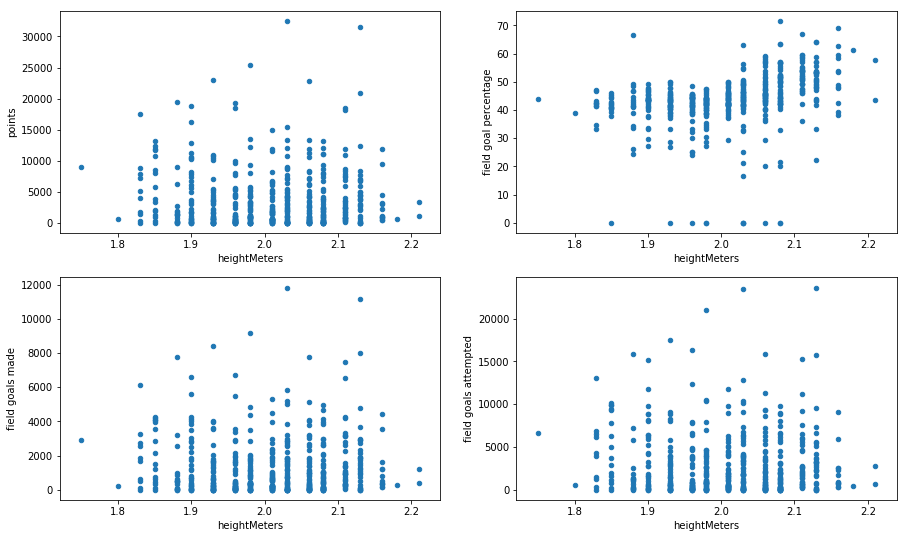

In [41]:
# player height versus points, field goal percentage, field goals made, and field goals attempted.

# As it can be seen, there is a relationship between the height of each player and the field goal percentage.
# Players with heights around 2.1 meters have upper percentage.


plt.figure(figsize=(15, 9))
plt.subplot(2, 2, 1)
analyse_df.plot.scatter(x="heightMeters", y="points", ax=plt.gca())
plt.subplot(2, 2, 2)
analyse_df.plot.scatter(x="heightMeters", y="fgp", ax=plt.gca())
plt.ylabel("field goal percentage")
plt.subplot(2, 2, 3)
analyse_df.plot.scatter(x="heightMeters", y="fgm", ax=plt.gca())
plt.ylabel("field goals made")
plt.subplot(2, 2, 4)
analyse_df.plot.scatter(x="heightMeters", y="fga", ax=plt.gca())
plt.ylabel("field goals attempted")

Text(0, 0.5, 'field goals attempted')

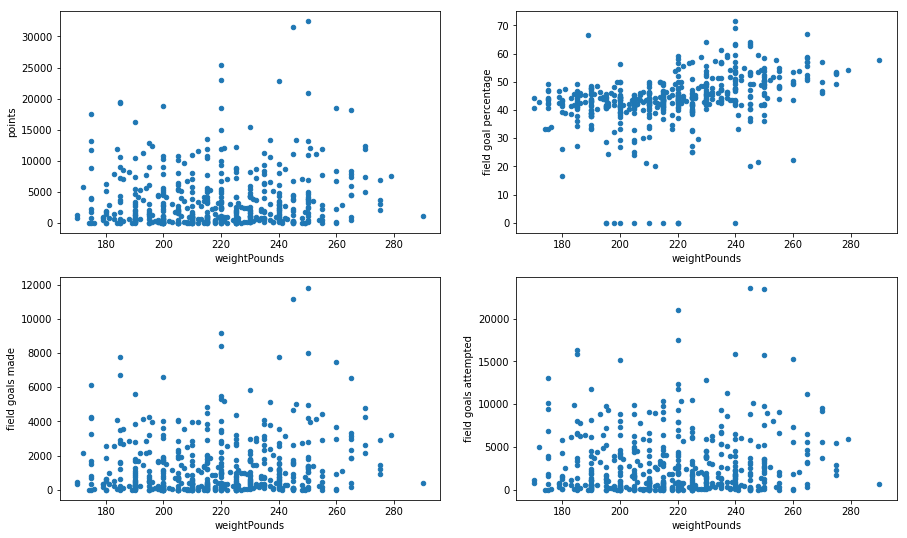

In [42]:
# player weight versus points, field goal percentage, field goals made, and field goals attempted.
# players with less weights made more points and goals.

plt.figure(figsize=(15, 9))
plt.subplot(2, 2, 1)
analyse_df.plot.scatter(x="weightPounds", y="points", ax=plt.gca())
plt.subplot(2, 2, 2)
analyse_df.plot.scatter(x="weightPounds", y="fgp", ax=plt.gca())
plt.ylabel("field goal percentage")
plt.subplot(2, 2, 3)
analyse_df.plot.scatter(x="weightPounds", y="fgm", ax=plt.gca())
plt.ylabel("field goals made")
plt.subplot(2, 2, 4)
analyse_df.plot.scatter(x="weightPounds", y="fga", ax=plt.gca())
plt.ylabel("field goals attempted")

Text(0, 0.5, 'field goal attempted')

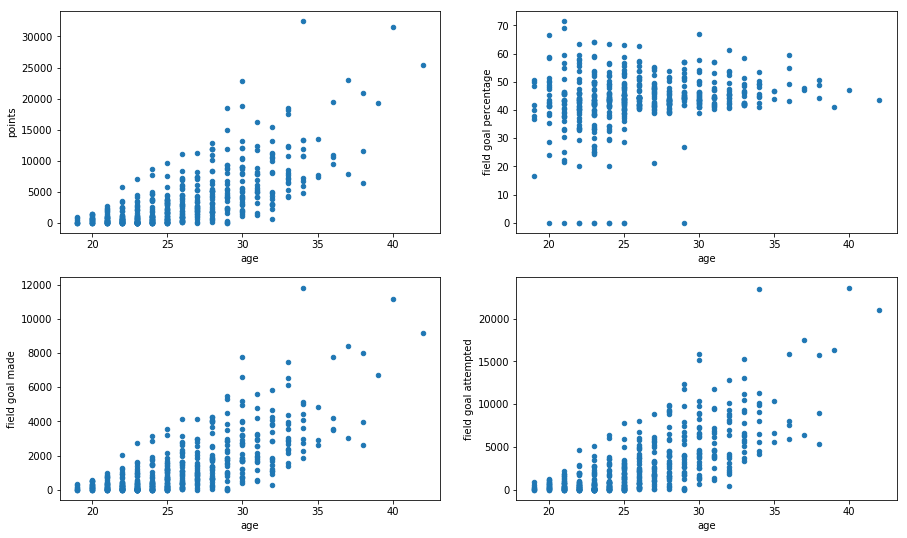

In [43]:
# player age versus points, field goal percentage, field goals made, and field goals attempted.
# Players within age 25-35 have better performance than others.

plt.figure(figsize=(15, 9))
plt.subplot(2, 2, 1)
analyse_df.plot.scatter(x="age", y="points", ax=plt.gca())
plt.subplot(2, 2, 2)
analyse_df.plot.scatter(x="age", y="fgp", ax=plt.gca())
plt.ylabel("field goal percentage")
plt.subplot(2, 2, 3)
analyse_df.plot.scatter(x="age", y="fgm", ax=plt.gca())
plt.ylabel("field goal made")
plt.subplot(2, 2, 4)
analyse_df.plot.scatter(x="age", y="fga", ax=plt.gca())
plt.ylabel("field goal attempted")

Text(0, 0.5, 'field goals attempted')

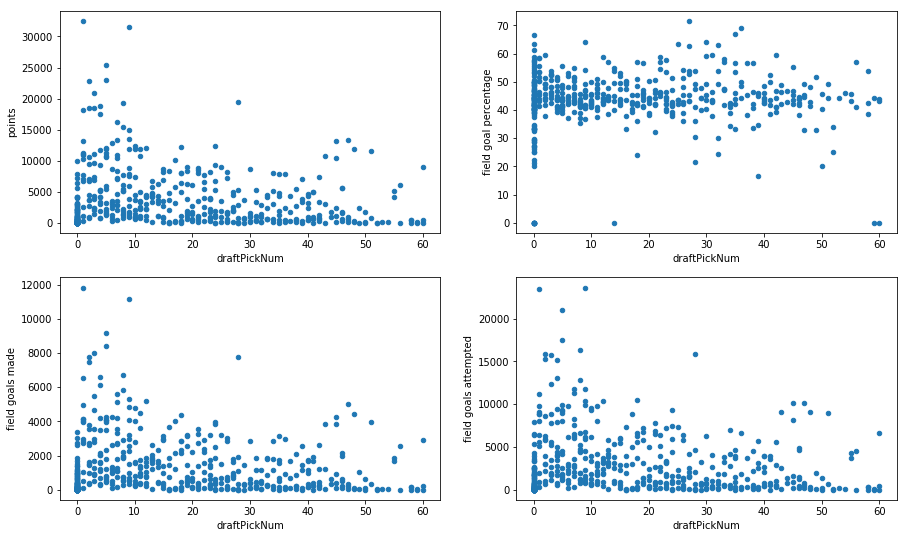

In [44]:
# player draft pick number versus points, field goal percentage, field goals made, and field goals attempted.


plt.figure(figsize=(15, 9))
plt.subplot(2, 2, 1)
analyse_df.plot.scatter(x="draftPickNum", y="points", ax=plt.gca())
plt.subplot(2, 2, 2)
analyse_df.plot.scatter(x="draftPickNum", y="fgp", ax=plt.gca())
plt.ylabel("field goal percentage")
plt.subplot(2, 2, 3)
analyse_df.plot.scatter(x="draftPickNum", y="fgm", ax=plt.gca())
plt.ylabel("field goals made")
plt.subplot(2, 2, 4)
analyse_df.plot.scatter(x="draftPickNum", y="fga", ax=plt.gca())
plt.ylabel("field goals attempted")

Text(0, 0.5, 'field goals attempted')

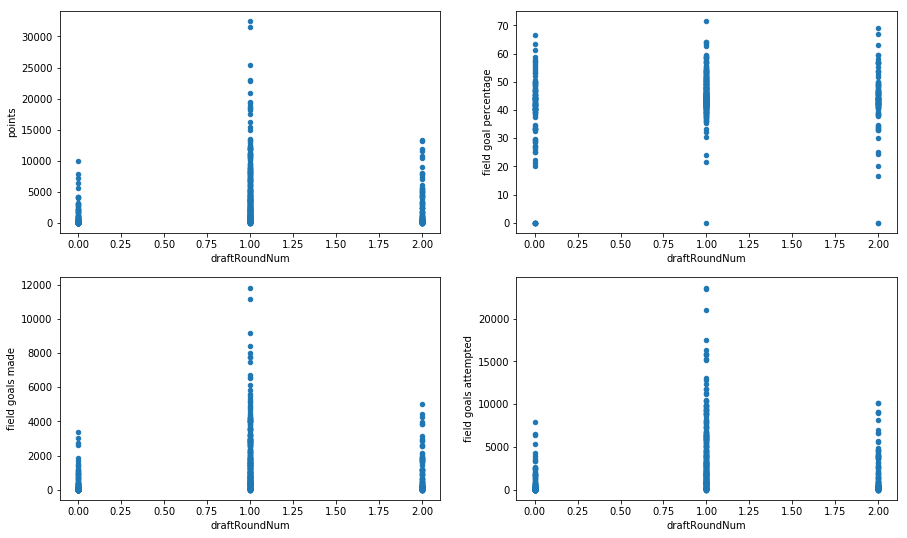

In [45]:
# player draft round number versus points, field goal percentage, field goals made, and field goals attempted.


plt.figure(figsize=(15, 9))
plt.subplot(2, 2, 1)
analyse_df.plot.scatter(x="draftRoundNum", y="points", ax=plt.gca())
plt.subplot(2, 2, 2)
analyse_df.plot.scatter(x="draftRoundNum", y="fgp", ax=plt.gca())
plt.ylabel("field goal percentage")
plt.subplot(2, 2, 3)
analyse_df.plot.scatter(x="draftRoundNum", y="fgm", ax=plt.gca())
plt.ylabel("field goals made")
plt.subplot(2, 2, 4)
analyse_df.plot.scatter(x="draftRoundNum", y="fga", ax=plt.gca())
plt.ylabel("field goals attempted")

In [46]:
# player position versus average points, average field goal percentage, average field goals made, 
# and average field goals attempted.

# Position C-F can make better points and have more goals than other psitions.

analyse_pos1 = analyse_df.groupby("pos")["points"].mean()
analyse_pos2 = analyse_df.groupby("pos")["fgp"].mean()
analyse_pos3 = analyse_df.groupby("pos")["fgm"].mean()
analyse_pos4 = analyse_df.groupby("pos")["fga"].mean()

Text(0, 0.5, 'average field goals attempted')

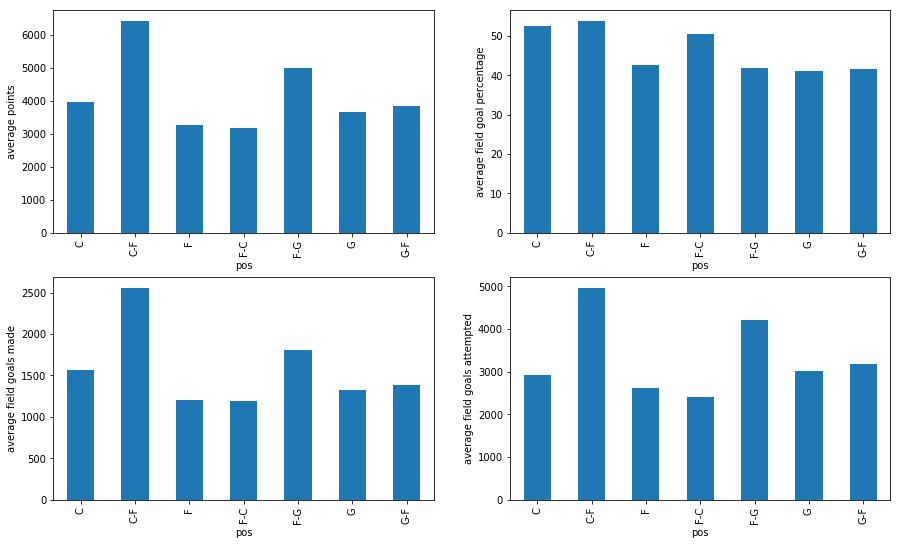

In [47]:
plt.figure(figsize=(15, 9))
plt.subplot(2, 2, 1)
analyse_pos1.plot.bar()
plt.ylabel("average points")
plt.subplot(2, 2, 2)
analyse_pos2.plot.bar()
plt.ylabel("average field goal percentage")
plt.subplot(2, 2, 3)
analyse_pos3.plot.bar()
plt.ylabel("average field goals made")
plt.subplot(2, 2, 4)
analyse_pos4.plot.bar()
plt.ylabel("average field goals attempted")

In [48]:
# Free throw percentage versus assists per game and total assists

# Players with 60%-80% of ftp have more assists compared to other players.

DF.ftp = pd.to_numeric(DF.ftp)
DF.apg = pd.to_numeric(DF.apg)
DF.assists = pd.to_numeric(DF.assists)

Text(0, 0.5, 'Total assists')

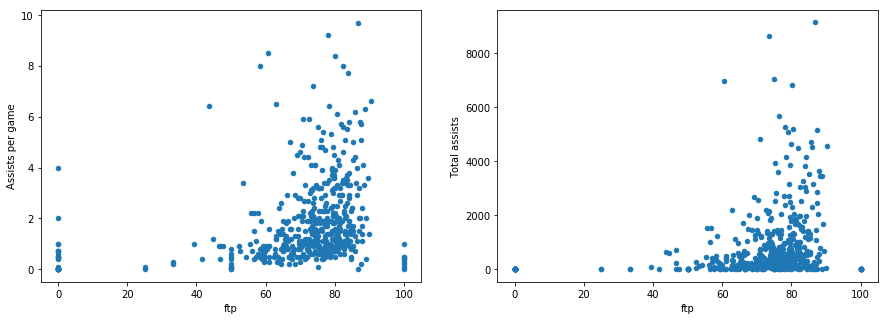

In [49]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
DF.plot.scatter(x="ftp", y="apg", ax=plt.gca())
plt.ylabel("Assists per game")
plt.subplot(1, 2, 2)
DF.plot.scatter(x="ftp", y="assists", ax=plt.gca())
plt.ylabel("Total assists")